In [127]:
import yfinance as yf

stock_tickers =['META', 'NFLX', 'TSLA']

database = yf.download(stock_tickers,start='2012-01-01',end ='2021-12-30')
database = database['Adj Close']
data = database.dropna().pct_change(1).dropna()
data

[*********************100%***********************]  3 of 3 completed


Ticker,META,NFLX,TSLA
Date,,,
2012-05-21 00:00:00+00:00,-0.109861,0.025443,0.043904
2012-05-22 00:00:00+00:00,-0.089039,-0.056175,0.070559
2012-05-23 00:00:00+00:00,0.032258,0.062029,0.007143
2012-05-24 00:00:00+00:00,0.032187,-0.022806,-0.023855
2012-05-25 00:00:00+00:00,-0.033909,-0.000711,-0.015522
...,...,...,...
2021-12-22 00:00:00+00:00,-0.011221,0.015407,0.074947
2021-12-23 00:00:00+00:00,0.014495,-0.000244,0.057619
2021-12-27 00:00:00+00:00,0.032633,-0.001580,0.025248


In [128]:
import numpy as np

def MV_Criterion(weight,data):
    Lambda = 3
    W = 1
    Wbar= (1+0.25)/100
    
    portfolio_return = np.multiply(data,np.transpose(weight))
    portfolio_return = portfolio_return.sum(axis=1)
    
    mean = np.mean(portfolio_return,axis=0)
    std = np.std(portfolio_return,axis=0)
    criterion = (Wbar**(-1-Lambda))/1+Lambda +(Wbar**-Lambda)*W*mean - (Wbar**(-1-Lambda))*Lambda*0.5*W**2*std**2
    
    return -1*criterion
    

In [129]:

import numpy as np
from scipy.optimize import Bounds, minimize

validation_score = 0.3
train_size = int(len(data)*(1-validation_score))
train_data = data.iloc[:train_size,:]
test_data = data.iloc[train_size:,:]

n = data.shape[1]
x0 = np.ones(n)

cons = ({'type':'eq','fun':lambda x:np.sum(abs(x))-1})

Bounds = [(0,1) for i in range(0,n)]

res = minimize(MV_Criterion,x0,args=train_data,method="SLSQP",constraints=cons,bounds=Bounds,options={'disp':True})
optimal_weight=res.x
optimal_portfolio_return = np.multiply(test_data,np.transpose(optimal_weight))
optimal_portfolio_return = optimal_portfolio_return.sum(axis=1)

print(optimal_weight)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -40937879.2485894
            Iterations: 7
            Function evaluations: 34
            Gradient evaluations: 7
[0.53111453 0.22995115 0.23893432]


In [130]:
def beta_function(portfolio,ben = "^GSPC"):
    benchmarck = yf.download(ben, start='2012-01-01', end='2021-12-30')["Adj Close"]
    benchmarck = benchmarck.dropna().pct_change(1)
    join = pd.concat((portfolio,benchmarck), axis=1).dropna()
    
    cov = np.cov(join,rowvar=False)[0][1]
    var = np.cov(join,rowvar = False)[1][1]
    
    return cov/var

In [131]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt


def backtest_riskmanagement(weight, database, ben="^GSPC", timeframe=252, CR=True):


    portfolio = np.multiply(database, np.transpose(weight))
    portfolio = portfolio.sum(axis=1)
    
    columns = database.columns
    columns = [i for i in columns]
    
    # Calculating the beta
    benchmarck = yf.download(ben, start='2012-01-01', end='2021-12-30')["Adj Close"]
    benchmarck = benchmarck.dropna().pct_change(1)
    join = pd.concat((portfolio, benchmarck), axis=1).dropna()
    
    cov = np.cov(join, rowvar=False)[0][1]
    var = np.cov(join, rowvar=False)[1][1]
    
    beta = cov/var
    
    # Calculating the alpha
    mean_stock_return = join.iloc[:,0].mean() * timeframe
    mean_market_return = join.iloc[:,1].mean() * timeframe
    
    alpha = mean_stock_return - beta * mean_market_return
    
    # Calculating the Sharpe ratio
    mean = portfolio.mean() * timeframe
    std = portfolio.std() * np.sqrt(timeframe)
    Sharpe = mean/std
    
    # Calculating the Sortino ratio
    std_s = portfolio[portfolio < 0].std() * np.sqrt(timeframe)
    Sortino = mean/std_s
    
    # Calculating the drawdown
    cum_ret = (portfolio + 1).cumprod()
    running_max = np.maximum.accumulate(cum_ret.dropna())
    running_max[running_max < 1] = 1
    
    
    Drawdown = (cum_ret/running_max - 1) 
    min_drawdown = -Drawdown.min()
    
    # Calculating the VaR and cVaR
    theta = 0.01
    
    n = 100000
    t = int(n * theta)
    vec = pd.DataFrame(np.random.normal(mean, std, size=(n,)), columns=['Simulations'])
    
    # Corrected VaR and cVaR calculation
    sorted_sims = vec.sort_values(by='Simulations')
    VaR = -sorted_sims.iloc[t]['Simulations']
    cVaR = -sorted_sims.iloc[:t]['Simulations'].mean()
    
    # Calculating the Contributing Risk
    
    num_assets = len(weight)
    res_asset_risk = []

    for i in range(num_assets):
        asset_risk = beta_function(database.iloc[:, i], ben=ben) * weight[i]
        res_asset_risk.append(asset_risk)
    
    res_asset_risk = res_asset_risk / np.sum(res_asset_risk)
    
    print(
    f"""
    -----------------------------------------------------------
    Portfolio:
    {columns}
    -----------------------------------------------------------
    Beta:       {np.round(beta, 3)} 
    Alpha:      {np.round(alpha, 3)}
    Sharpe:     {np.round(Sharpe, 3)} 
    Sortino:    {np.round(Sortino, 3)}
    -----------------------------------------------------------
    VaR:        {np.round(VaR, 3)}
    cVaR:       {np.round(cVaR, 3)}
    VaR/cVaR:   {np.round(cVaR / VaR, 3)}
    Drawdown:   {np.round(min_drawdown * 100, 2)}
    -----------------------------------------------------------
    
    """)
    
    print("Asset Risk Contributions:")
    for asset, risk in zip(columns, res_asset_risk):
        print(f"{asset}: {np.round(risk * 100, 2)} %")
    print("-----------------------------------------------------------")
    
    # Plot cumulative return with benchmark
    plt.figure(figsize=(10, 6))
    plt.plot(portfolio.cumsum(), label="Portfolio Cumulative Returns", color="blue")
    # plt.plot(benchmarck.cumsum(), label="Benchmark Returns", color="green")
    plt.title("CUMULATIVE RETURN", size=15)
    plt.legend()
    plt.grid()
    plt.show()


    # Plot drawdown
    plt.figure(figsize=(10, 6))
    plt.fill_between(Drawdown.index, Drawdown * 100, 0, color="#E95751")
    plt.title("DRAWDOWN", size=15)
    plt.show()

    # Plot risk contribution portfolio if CR exists
    
    plt.figure(figsize=(10, 6))
    plt.bar(columns, res_asset_risk, color="#B96553")
    plt.axhline(0, color="#53A7B9")
    plt.grid(axis="y")
    plt.title("RISK CONTRIBUTION PORTFOLIO", size=15)
    plt.xlabel("Assets")
    plt.ylabel("Risk Contribution")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



    -----------------------------------------------------------
    Portfolio:
    ['META', 'NFLX', 'TSLA']
    -----------------------------------------------------------
    Beta:       1.04 
    Alpha:      0.289
    Sharpe:     1.526 
    Sortino:    1.961
    -----------------------------------------------------------
    VaR:        0.273
    cVaR:       0.389
    VaR/cVaR:   1.422
    Drawdown:   37.46
    -----------------------------------------------------------
    
    
Asset Risk Contributions:
META: 53.16 %
NFLX: 16.52 %
TSLA: 30.31 %
-----------------------------------------------------------


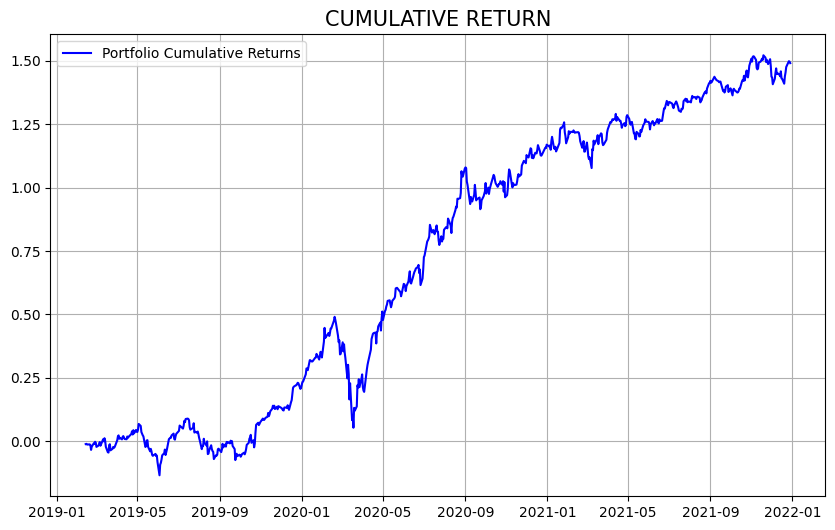

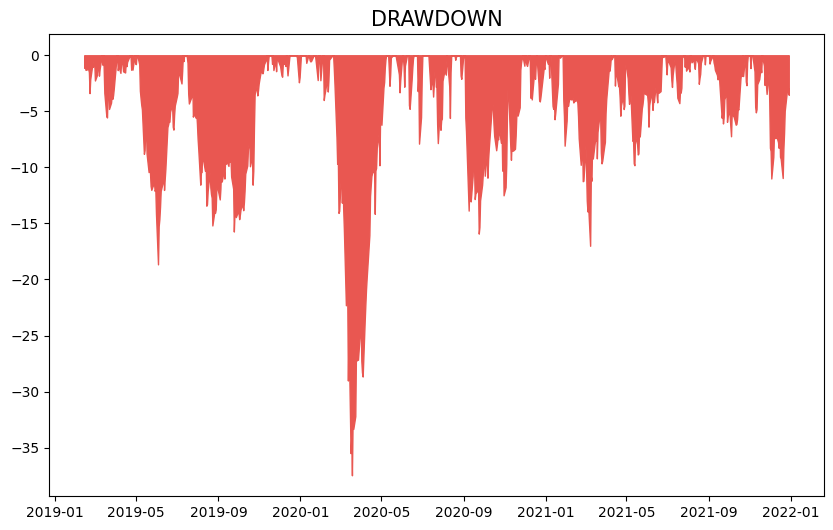

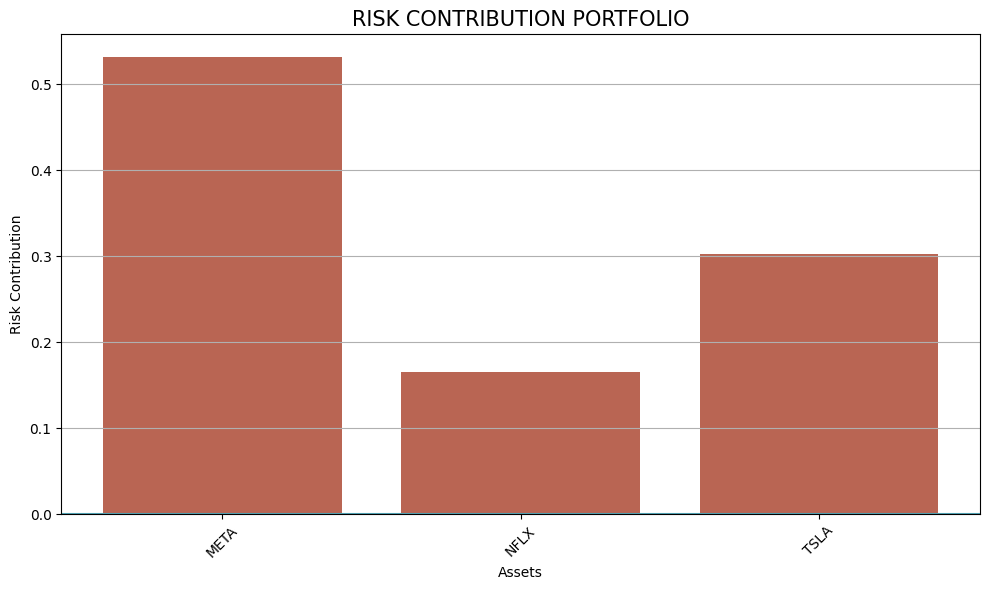

None


In [132]:
print(backtest_riskmanagement(optimal_weight,test_data,ben="^GSPC",timeframe=252))